<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/AIPI540_IP_fusion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

In [1]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [2]:
if COLAB_FLAG:
    !pip install pydicom==2.1.2
    !pip install monai seaborn sentence_transformers
    !git clone 'https://github.com/mille055/AIPI540_individual_project.git'

    


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
#import monai
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime
from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

# import monai
# from monai.data import DataLoader, ImageDataset
# from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    val_datafile = '/content/AIPI540_individual_project/data/valfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'

### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *
#from train_pixel_model import train_pix_model, test_pix_model, ImgDataset, image_to_tensor, get_pixel_preds_and_probs
#from train_meta_model import train_fit_parameter_trial, train_meta_model, calc_feature_importances, get_meta_probs, meta_inference
#from train_text_model import train_text_log_model, load_text_data, get_nlp_inference
from NLP.NLP_inference import get_NLP_inference
from NLP.NLP_training import train_NLP_model
from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import CustomResNet50
from cnn.cnn_data_loaders import get_data_loaders
from metadata.meta_inference import meta_inference, calc_feature_importances
from metadata.meta_training import train_fit_parameter_trial, train_meta_model, evaluate_meta_model
from fusion_model.fus_model import FusionModel
from fusion_model.fus_inference import get_fusion_inference
from fusion_model.fus_training import train_fusion_model, CustomDataset
from model_container import ModelContainer
from process_tree import Processor
# from AIPI540_individual_project.scripts.train_pixel_model import train_model
# from AIPI540_individual_project.scripts.train_text_model import load_text_data, train_text_model, list_incorrect_text_predictions
# from AIPI540_individual_project.scripts.utils import *

# Load Datasets


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile)



In [7]:
# prepares the features (preprocess normalizes/binarizes/ordinalizes the columns and limits to the feature set) and gets the labels
X_train_meta = preprocess(train_df)
X_val_meta = preprocess(val_df)
X_test_meta = preprocess(test_df)
y_train = train_df.label
y_val = val_df.label
y_test = test_df.label


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


## Get Inferences from Saved Models

In [8]:
# Load the pickled model
with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)



In [9]:
Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, meta_model, feats_to_keep)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, meta_model, feats_to_keep)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, meta_model, feats_to_keep)

Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [10]:

meta_train_results_df = make_results_df(Tpreds, Tprobs, Ty, train_df)
meta_val_results_df = make_results_df(Vpreds, Vprobs, Vy, val_df)
meta_test_results_df = make_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.64      0.64      0.64        61
           6       0.23      0.82      0.35        17
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.93      0.96        28
          19       0.66      0.91      0.76        23
          23       0.00      0.00      0.00        20
          25       0.87      0.83      0.85        47

    accuracy                           0.78       432
   macro avg       0.76   

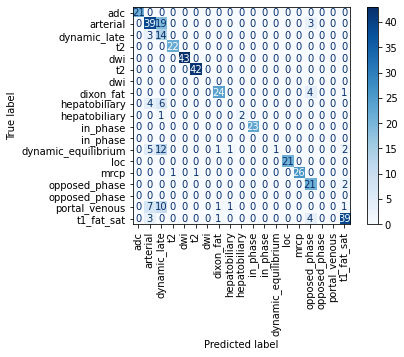

<Figure size 1800x1800 with 0 Axes>

In [11]:
f = display_and_save_results(meta_test_results_df.preds, meta_test_results_df.true, fn='meta', saveflag=False)


Preprocessing metadata for Random Forest classifier.
Have received 432 entries.
accuracy is 0.7662037037037037
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.58      0.64      0.61        61
           6       0.23      0.82      0.35        17
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.96      0.98        28
          19       0.70      0.70      0.70        23
          23       0.50      0.05      0.09        20
          25       0.73 

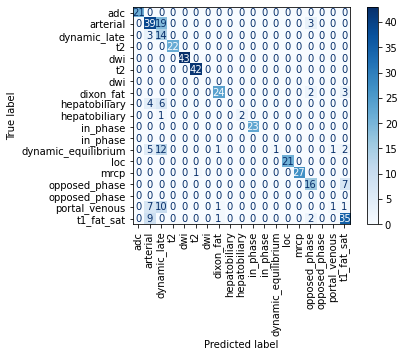

<Figure size 1800x1800 with 0 Axes>

In [11]:
## just checking to make sure the saved model is better than vanilla RF
from sklearn.ensemble import RandomForestClassifier
vanilla_model = RandomForestClassifier(min_samples_leaf=2)
vanilla_model.fit(X_train_meta[feats_to_keep], y_train)
vanillapreds, vanillaprobs, vanillay, vanillaacc = meta_inference(test_df, vanilla_model, feats_to_keep)
print('accuracy is', vanillaacc)
vanilla_results_df = make_results_df(vanillapreds, vanillaprobs, TEy, test_df)
f= display_and_save_results(vanilla_results_df.preds, vanilla_results_df.true, saveflag=False)
print(vanilla_model.get_params())

It shows no significant change in the overall accuracy compared with the default parameters...

### Getting pixel inference results

In [12]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pix = CustomResNet50(19)

# Load the saved state dictionary
saved_state_dict = torch.load('../models/pixel_model_041623.pth', map_location=device)

# Modify the keys to add the 'resnet50.' prefix
modified_state_dict = {f'resnet50.{k}': v for k, v in saved_state_dict.items()}

# Load the modified state dictionary into the current model
model_pix.load_state_dict(modified_state_dict)
model_pix = model_pix.to(device)


In [13]:

#pixel_train_preds, pixel_train_probs = pixel_inference(model_pix, train_df.fname.tolist())
#pixel_val_preds, pixel_val_probs = pixel_inference(model_pix, val_df.fname.to_list())
pixel_test_preds, pixel_test_probs = pixel_inference(model_pix, test_df.fname.to_list())

In [14]:
#pixel_train_results_df = make_results_df(pixel_train_preds, pixel_train_probs, Ty, train_df)
#pixel_val_results_df = make_results_df(pixel_val_preds, pixel_val_probs, Vy, val_df)
pixel_test_results_df = make_results_df(pixel_test_preds, pixel_test_probs, TEy, test_df)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.83      0.85      0.84        61
           6       0.89      1.00      0.94        17
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        43
           9       1.00      0.98      0.99        42
          11       1.00      1.00      1.00        29
          12       0.00      0.00      0.00        10
          13       1.00      0.33      0.50         3
          14       1.00      0.83      0.90        23
          16       0.57      0.36      0.44        22
          17       1.00      0.95      0.98        21
          18       1.00      1.00      1.00        28
          19       0.81      0.96      0.88        23
          23       0.42      0.75      0.54        20
          25       0.90      0.91      0.91        47

    accuracy                           0.88       432
   macro avg       0.84   

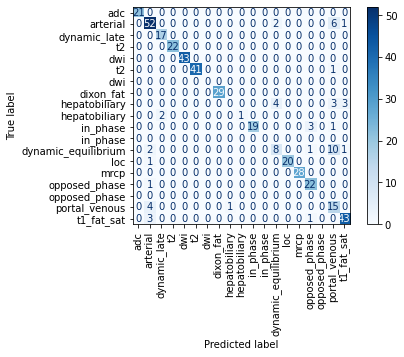

<Figure size 1800x1800 with 0 Axes>

In [15]:
f = display_and_save_results(pixel_test_results_df.preds, pixel_test_results_df.true, fn='pixel', saveflag=False)

### Getting NLP inference


In [16]:
# Load the pickled model
with open('../models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

In [17]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
senttrans_model = SentenceTransformer(sentence_encoder, device=device)



In [18]:
from NLP.NLP_training import train_NLP_model
train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, text_model_T = train_NLP_model(train_df, val_df, test_df, senttrans_model=senttrans_model)
print(train_acc, val_acc, test_acc)

Accuracy on the training set is 0.953
size of preds_val is  354
Accuracy on the val set is 0.960
Accuracy on the test set is 0.963
0.9525200876552228 0.96045197740113 0.9629629629629629


In [19]:
# testing on a single row
get_NLP_inference(NLP_model, filenames = [train_df.fname[0]])

/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (35-68)/0052.dcm


(array([8]),
 array([2.05830697e-02, 1.09033896e-02, 9.21967902e-04, 1.18682510e-03,
        8.91965271e-01, 2.32301806e-02, 3.88249769e-04, 1.11549243e-02,
        2.69171811e-03, 8.54710155e-04, 5.62693953e-03, 3.48056692e-04,
        4.63554106e-03, 2.39543446e-03, 2.17179292e-03, 7.22289270e-03,
        3.47885500e-04, 3.88035863e-03, 9.49079232e-03]))

In [20]:

nlp_test_preds, nlp_test_probs = get_NLP_inference(NLP_model, test_df.fname.tolist())
# #nlp_train_preds, nlp_train_probs = get_NLP_inference(NLP_model, train_df.fname.tolist())
# #nlp_val_preds, nlp_val_probs = get_NLP_inference(NLP_model, val_df.fname.tolist())


/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_spli

In [21]:
print(classification_report(nlp_test_preds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.98      0.95      0.97        63
           6       1.00      0.85      0.92        20
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       0.86      1.00      0.93        25
          12       0.60      1.00      0.75         6
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00        23
          16       1.00      0.81      0.90        27
          17       1.00      1.00      1.00        21
          18       0.96      1.00      0.98        27
          19       1.00      1.00      1.00        23
          23       1.00      0.91      0.95        22
          25       0.94      0.96      0.95        46

    accuracy                           0.96       432
   macro avg       0.90   

In [22]:
# nlp_train_results_df = make_results_df(nlp_train_preds, nlp_train_probs, Ty, train_df)
# nlp_val_results_df = make_results_df(nlp_val_preds, nlp_val_probs, Vy, val_df)
nlp_test_results_df = make_results_df(nlp_test_preds, nlp_test_probs, TEy, test_df)

# #change names of preds, probs 
# for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
# #    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)


In [23]:
# #change names of preds, probs 
# for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
#     frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)

# for frame_df in [pixel_train_results_df, pixel_val_results_df, pixel_test_results_df]:
#     frame_df.rename(columns={'preds':'pixel_preds', 'probs':'pixel_probs'}, inplace=True)

# for frame_df in [meta_train_results_df, meta_val_results_df, meta_test_results_df]:
#     frame_df.rename(columns={'preds':'meta_preds', 'probs':'meta_probs'}, inplace=True)


## Create fusion model

In [24]:
# fusion_train_df = pixel_train_results_df.copy()
# fusion_train_df[['meta_preds', 'meta_probs']] = meta_train_results_df[['meta_preds', 'meta_probs']]
# fusion_train_df[['nlp_preds', 'nlp_probs']] = nlp_train_results_df[['nlp_preds', 'nlp_probs']]


In [25]:
# fusion_val_df = pixel_val_results_df.copy()
# fusion_val_df[['meta_preds', 'meta_probs']] = meta_val_results_df[['meta_preds', 'meta_probs']]
# fusion_val_df[['nlp_preds', 'nlp_probs']] = nlp_val_results_df[['nlp_preds', 'nlp_probs']]


In [26]:
# fusion_test_df = pixel_test_results_df.copy()
# fusion_test_df[['meta_preds', 'meta_probs']] = meta_test_results_df[['meta_preds', 'meta_probs']]
# fusion_test_df[['nlp_preds', 'nlp_probs']] = nlp_test_results_df[['nlp_preds', 'nlp_probs']]


In [23]:
# loading the data back from pickled dataframes
with open('../data/fusion_train.pkl', 'rb') as file:
    ftrain = pickle.load(file)

with open('../data/fusion_val.pkl', 'rb') as file:
    fval = pickle.load(file)

with open('../data/fusion_test.pkl', 'rb') as file:
    ftest = pickle.load(file)


#adjust the labels to consecutive numbers 0-18 and storing the original labels into 'class'
ftest['class'] = ftest['true']
ftrain['class'] = ftrain['true']
fval['class'] = fval['true']

ftest['true'] = ftest['true'].apply(lambda x: classes.index(x))
ftrain['true'] = ftrain['true'].apply(lambda x: classes.index(x))
fval['true'] = fval['true'].apply(lambda x: classes.index(x))

#sanity check
#print(set(ftest['true'].tolist()))

# get model container for the base models
model_container=ModelContainer()

#  Instantiate FusionModel
fusion_model = FusionModel(model_container, pretrained=False)
fusion_model_no_nlp = FusionModel(model_container, pretrained=False, include_nlp=False) 


# Define the loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)
p_optimizer = optim.Adam(fusion_model_no_nlp.parameters(), lr=0.001)


train_dataset = CustomDataset(ftrain)
val_dataset = CustomDataset(fval)
test_dataset = CustomDataset(ftest)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)




In [ ]:

# already have the trained model with all 3 modalities

#trained_model, training_history_with_nlp = train_fusion_model(fusion_model, train_loader, val_loader, test_loader, device, optimizer, loss_fn = criterion, num_epochs=30, include_nlp=True)
   
# save trained model
#model_weights_path = '../models/fusion_model_weights_new.pth'
#torch.save(trained_model.state_dict(), model_weights_path)

In [24]:
trained_model_no_nlp, training_history_without_nlp = train_fusion_model(fusion_model_no_nlp, train_loader, val_loader, test_loader, device, p_optimizer, loss_fn=criterion, num_epochs=30, include_nlp=False)
 

Epoch 1/30
----------
Train Loss: 2.9179 Acc: 0.0606
Validation Loss: 2.8487 Acc: 0.1328
Epoch 2/30
----------
Train Loss: 2.7779 Acc: 0.2710
Validation Loss: 2.7337 Acc: 0.3898
Epoch 3/30
----------
Train Loss: 2.6413 Acc: 0.5493
Validation Loss: 2.6210 Acc: 0.5621
Epoch 4/30
----------
Train Loss: 2.5079 Acc: 0.8181
Validation Loss: 2.5117 Acc: 0.7260
Epoch 5/30
----------
Train Loss: 2.3778 Acc: 0.9094
Validation Loss: 2.4055 Acc: 0.7966
Epoch 6/30
----------
Train Loss: 2.2513 Acc: 0.9613
Validation Loss: 2.3022 Acc: 0.8249
Epoch 7/30
----------
Train Loss: 2.1283 Acc: 0.9730
Validation Loss: 2.2027 Acc: 0.8333
Epoch 8/30
----------
Train Loss: 2.0094 Acc: 0.9744
Validation Loss: 2.1069 Acc: 0.8503
Epoch 9/30
----------
Train Loss: 1.8951 Acc: 0.9774
Validation Loss: 2.0144 Acc: 0.8588
Epoch 10/30
----------
Train Loss: 1.7852 Acc: 0.9788
Validation Loss: 1.9261 Acc: 0.8588
Epoch 11/30
----------
Train Loss: 1.6802 Acc: 0.9788
Validation Loss: 1.8418 Acc: 0.8672
Epoch 12/30
-------

In [25]:
## performance still high without the NLP portion of the model? saving it here
model_weights_path_no_nlp = '../models/fusion_model_weights_no_nlp042223.pth'
torch.save(trained_model_no_nlp.state_dict(), model_weights_path_no_nlp)


In [26]:


# Instantiate your model
Fmodel = FusionModel(model_container)
Fmodel_no_nlp = FusionModel(model_container, include_nlp=False)

# Load the saved state_dict (model weights)
saved_model_weights = torch.load('../models/fusion_model_weights042223.pth')
saved_model_weights_no_nlp = torch.looad('..models/fusion_model_weights_no_nlp042223.pth')

# Load the state_dict into the model
Fmodel.load_state_dict(saved_model_weights)
Fmodel_no_nlp.load_state_dict(saved_model_weights_no_nlp)

# Set the model to evaluation mode
Fmodel.eval()

predictions = []
probs = []

predictions_nn = []
probs_nn = []

for index, row in X_test_meta.iterrows():
    pred, prob, ts_df = Fmodel.get_fusion_inference(row)
    predictions.append(pred)
    probs.append(prob)

for index, row in X_test_meta.iterrows():
    pred_nn, prob_nn, ts_df_nn = Fmodel_no_nlp.get_fusion_inference(row)
    predictions_nn.append(pred_nn)
    probs_nn.append(prob_nn)

comparison_fusion_df = pd.DataFrame({'preds': predictions, 'probs': probs, 'preds_no_nlp': predictions_nn, 'probs_no_nlp': probs_nn, 'true': TEy})
comparison_fusion_df



FileNotFoundError: [Errno 2] No such file or directory: '../models/fusion_model_weights_new.pth'

In [29]:
fusion_test_results_df = make_results_df(preds, probs, ftest.true.apply(lambda x: classes[x]), test_df)

NameError: name 'preds' is not defined

In [ ]:
# fusion_test_results_df

In [ ]:
# num_epochs = 20
# batch_size = 32

# for epoch in range(num_epochs):
#     for i in range(0, len(y_train_fusion), batch_size):
#         actual_batch_size = min(batch_size, len(Xtrain1) - i)
#         X1_batch = torch.tensor(np.array(Xtrain1[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         X2_batch = torch.tensor(np.array(Xtrain2[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         #X3_batch = torch.tensor(np.array(Xtrain3[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         y_batch = torch.tensor(y_train_fusion[i:i+actual_batch_size], dtype=torch.long)

#         # print(f"X1_batch shape: {X1_batch.shape}")
#         # print(f"X2_batch shape: {X2_batch.shape}")
#         # print(f"X3_batch shape: {X3_batch.shape}")
#         # print(f"y_batch shape: {y_batch.shape}")


#         p_optimizer.zero_grad()
#         outputs = meta_and_pixel_fusion_model(X1_batch, X2_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         p_optimizer.step()

#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


In [ ]:
# import torch.nn.functional as F
# # Evaluate the model with the test data
# with torch.no_grad():
#     X1_test_t = torch.tensor(Xtest1, dtype=torch.float32)
#     X2_test_t = torch.tensor(Xtest2, dtype=torch.float32)
#     #X3_test_t = torch.tensor(Xtest3, dtype=torch.float32)
#     y_test_t = torch.tensor(y_test_fusion, dtype=torch.long)

#     outputs = meta_and_pixel_fusion_model(X1_test_t, X2_test_t)
#     g_probabilities = F.softmax(outputs, dim=1)  # Apply softmax to the outputs

#     _, g_predicted = torch.max(outputs, 1)
#     correct = (g_predicted == y_test_t).sum().item()
#     g_accuracy = correct / len(y_test_t) * 100

# print(f'Test accuracy: {g_accuracy}%')

In [ ]:
# # for classification report and CM:
# # Move the tensor to the CPU if it's on the GPU
# if g_predicted.is_cuda:
#     g_predicted = g_predicted.cpu()
# g_predicted_list = g_predicted.tolist()
# g_predictions = [classes[g] for g in g_predicted_list]


In [ ]:
# label_list = [abd_label_dict[str(x)]['short'] for x in actual_classes]
# label_list

In [ ]:
# print(classification_report(g_predictions, TEy, labels = actual_classes, target_names = label_list))

In [ ]:
# def duplicated_cm_plot(ytrue, ypreds, classes, fname):
    
#     cm = confusion_matrix(ytrue, ypreds, labels=classes)
#     plt.figure(figsize=(25, 25))
#     plt.tight_layout()
#     ConfusionMatrixDisplay(cm, display_labels=[abd_label_dict[str(x)]['short'] for x in classes]).plot(xticks_rotation = 'vertical', cmap='Blues')
#     plt.savefig(fname + datetime.now().strftime('%Y%m%d') + ".png", dpi=300, bbox_inches='tight')

#     plt.show()

#     return plt


In [ ]:
# g_cm = duplicated_cm_plot(TEy,g_predictions, actual_classes, '../assets/figures/FigFusionMetaPixel')

In [ ]:
# # for classification report and CM:
# # Move the tensor to the CPU if it's on the GPU
# if f_predicted.is_cuda:
#     f_predicted = f_predicted.cpu()
# f_predicted_list = f_predicted.tolist()
# f_predictions = [classes[f] for f in f_predicted_list]


In [ ]:
# f_cm = duplicated_cm_plot(TEy,f_predictions, actual_classes, '../assets/figures/FigFusionAll')

In [ ]:
# # Save the trained fusion models to a file
# with open('fusion_model041623.pkl', 'wb') as f:
#     pickle.dump(fusion_model, f)

In [ ]:
# # Save the trained fusion models to a file
# with open('meta_and_pixel_fusion_model041623.pkl', 'wb') as f:
#     pickle.dump(meta_and_pixel_fusion_model, f)

# Inference fusion model

In [ ]:
# ### load models
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# with open('../models/text_model20230415.st', 'rb') as file:
#     NLP_model = pickle.load(file)

# with open('../models/meta_04152023.skl', 'rb') as file:
#     meta_model = pickle.load(file)


# with open('../models/fusion_model041623.pkl', 'rb') as file:
#     fusion_model = pickle.load(file)

# with open('../models/meta_and_pixel_fusion_model041623.pkl', 'rb') as file:
#     fusion_model_part = pickle.load(file)

# def load_pixel_model(modelpath, device=device, output_units = 19):
    
#     model = models.resnet50(pretrained=True) # Load the ResNet50 model 

#     # Replace the output layer to match the number of output units in your fine-tuned model
#     num_finetuned_output_units = output_units
#     num_features = model.fc.in_features
#     model.fc = torch.nn.Linear(num_features, num_finetuned_output_units)

#     # Load the saved state_dict
#     state_dict = torch.load(modelpath, map_location=device)
#     model.load_state_dict(state_dict)

#     return model

# pixel_model = load_pixel_model('../models/pixel_model_041623.pth')



In [ ]:



# def get_fusion_model_prediction(row, model1 = meta_model, model2=pixel_model, model3=NLP_model, fusion_model = fusion_model, device=device,features=feats_to_keep, num_classes=len(classes)):
#     #meta_data, pixel_data, text_data = extract_data_for_models(row)
    
#     prob1 = get_meta_probs(row, model1, features) 
#     prob1_tensor = torch.tensor(prob1, dtype=torch.float32).squeeze()
#     #print(f'shape of prob1_tensor is {prob1_tensor.shape}')
    
#     _, prob2 = get_pixel_preds_and_probs(model2, [row.fname], classes=classes)
#     prob2_tensor = torch.tensor(prob2, dtype=torch.float32)
#     #print(f'shape of prob2_tensor is {prob2_tensor.shape}')
    
    
#     _, prob3 = get_NLP_inference(model3, [row.fname], device, classes=classes)
#     prob3_tensor = torch.tensor(prob3, dtype=torch.float32)
#     #print(f'shape of prob3_tensor is {prob3_tensor.shape}')
    

#    # print(prob1_tensor, prob2_tensor, prob3_tensor)
#     #print(torch.cat((prob1_tensor, prob2_tensor, prob3_tensor), dim=0))

#     # Pass the tensors through the FusionModel
#     fused_output=  fusion_model(prob1_tensor, prob2_tensor, prob3_tensor)
    
#     # Get the predicted class and confidence score
#     predicted_class = classes[torch.argmax(fused_output, dim=0).item()]
#     confidence_score = torch.max(torch.softmax(fused_output, dim=0)).item()
    
#     return predicted_class, confidence_score

In [ ]:

# from model_container import ModelContainer
# from fusion_model.fus_model import FusionModel
# from process_tree import Processor

# old_data_site = '/volumes/cm7/Abdominal_MRI_dataset_split/test/'
# destionate_site = 'volumes/cm7/wacky'

model_container = ModelContainer()

fusion_model = FusionModel(cnn_model, metadata_model, nlp_model, fusion_weights, num_classes=len(classes), features=feats_to_keep, classes=classes, include_nlp=True)
   
# processor = Processor(old_data_site, destination_site, fusion_model=fusion_model, write_labels=True)
# new_processed_df = processor.pipeline_new_studies()

fus_preds = []
for i in range(20):
    fus_pred = get_fusion_inference(row=X_test_meta.iloc[i])
    fus_preds.append(fus_pred)
print(fus_preds)
#print(test_df.label.tolist()[:20])

### i need to have a preprocessed dataframe, or a method to 'preprocess' a single row for the meta but still have the other info...or pass it 
### a dataframe on a single row

In [ ]:
test_df.fname[0]

# Playing with writing results into DICOM metadata

In [ ]:

# moved to fus_inference
# def write_labels_into_dicom(series_group, label_num, conf_num, path):
#     #print('writing labels', label_num)
#     for dicom_file in series_group.fname.tolist():
#         filename = os.path.basename(dicom_file)
#         ds = dcmread(dicom_file, no_pixels=False)

#         private_creator_tag = pydicom.tag.Tag(0x0011, 0x0010)
#         custom_tag1 = pydicom.tag.Tag(0x0011, 0x1010)
#         custom_tag2 = pydicom.tag.Tag(0x0011, 0x1011)

#         # Check if private creator and custom tags already exist
#         if private_creator_tag not in ds or custom_tag1 not in ds or custom_tag2 not in ds:
#             # Create and add private creator element
#             private_creator = pydicom.DataElement(private_creator_tag, 'LO', 'PredictedClassInfo')
#             ds[private_creator_tag] = private_creator

#             # Create and add custom private tags
#             data_element1 = pydicom.DataElement(custom_tag1, 'IS', str(label_num))
#             data_element1.private_creator = 'PredictedClassInfo'
#             data_element2 = pydicom.DataElement(custom_tag2, 'DS', str(conf_num))
#             data_element2.private_creator = 'PredictedClassInfo'
#             ds[custom_tag1] = data_element1
#             ds[custom_tag2] = data_element2

#             modified_file_path = os.path.join(path, filename)
#             ds.save_as(modified_file_path)
#         else:
#             print(f"Custom tags already exist in {dicom_file}, skipping this file.")

#         modified_file_path = os.path.join(path, filename)
#         ds.save_as(modified_file_path)  






# playing with read world data

In [ ]:
# sys.path.append('../scripts')
# from fusion_model.fus_model import FusionModel
# from model_container import ModelContainer



In [5]:

data_dir = '/volumes/cm7/processed/'
destination_folder = '/volumes/cm7/testing_the_model'

models = ModelContainer()
fusion_model = FusionModel(models, num_classes=19)
processor = Processor(data_dir=data_dir, destination_folder=destination_folder, fusion_model=fusion_model)


In [6]:
new_data = processor.pipeline_new_studies()

Finding DICOM files. This may take a few minutes.
Reading DICOM files with extensions .dcm, .dicom, .dcim, or .ima. This may take a few minutes, depending on the number of files to read...
Preprocessing metadata for Random Forest classifier.
Have received 4135 entries.
/volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
Custom tags already exist in /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0001.dcm, skipping this file.
Custom tags already exist in /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0002.dcm, skipping this file.
Custom tags already exist in /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_

In [10]:
new_data.iloc[250:300]

fname  \
patientID    exam                                               series                                                                                                                                                                     
CmmDemoCase6 Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd 3Plane_Loc_SSFSE_1       3348        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0011.dcm   
                                                                                         3345        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0012.dcm   
                                                                                         3346        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0013.dcm   
                                                                                         3352        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0014.dcm   
                                                                                         3354        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0015.dcm   
                                                                                         3357        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0016.dcm   
                                                                                         3356        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0017.dcm   
                                                                ADC_(10_6_mm²s)[NoQ]_550 3838  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0001.dcm   
                                                                                         3833  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0002.dcm   
                                                                                         3832  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0003.dcm   
                                                                                         3843  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0004.dcm   
                                                                                         3840  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0005.dcm   
                                                                                         3845  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0006.dcm   
                                                                                         3846  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0007.dcm   
                                                                                         3856  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0008.dcm   
                                                                                         3851  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550

In [ ]:
def process_batch(df, data_dir, destination_folder, write_labels=True):

    df1 = df.copy()
    #print('In batch, columns are: ', df1.columns)
    batch = df1.groupby('patientID').apply(lambda x: process_patient(x, data_dir, destination_folder, write_labels))
    
    # print('writing labels into dicom in location ', dest_name)
    # for filename in batch.fname:

    return batch

def process_patient(patient_df, data_dir, destination_folder, write_labels):
    processed_exams = patient_df.groupby('exam').apply(lambda x: process_exam(x, data_dir, destination_folder, write_labels))
    return processed_exams


def process_exam(exam_df, data_dir, destination_folder, write_labels):
    # Group exam data by series and apply the process_series function
    processed_series = exam_df.groupby('series').apply(lambda x: process_series(x, data_dir, destination_folder))

    #result = pd.concat(processed_series)
    result = processed_series
    return result
    
def process_series(series_df, data_dir, destination_folder, write_labels, selection_fraction=0.5):
    # Sort the dataframe by file_info (or another relevant column)
    sorted_series = series_df.sort_values(by='fname')

    # Find the middle image index
    middle_index = int(len(sorted_series) * selection_fraction)

    # Get the middle image
    middle_image = sorted_series.iloc[middle_index]

    predicted_series_class, predicted_series_confidence = get_fusion_model_prediction(middle_image)

    sorted_series['predicted_class'] = predicted_series_class
    sorted_series['prediction_confidence'] = np.round(predicted_series_confidence, 2)

    #save_path = f'/volumes/cm7/processed/modified/{series_df.patientID}/{series_df.exam}/{series_df["series"]}/'

     # Define the save path relative to data_dir
    relative_path = os.path.relpath(series_df.fname.iloc[0], data_dir)
    save_path = os.path.join(data_dir, destination_folder, os.path.dirname(relative_path))

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    if write_labels:
        #print('writing new data into', save_path)
        write_labels_into_dicom(sorted_series, label_num=predicted_series_class,
                            conf_num=np.round(predicted_series_confidence, 3), path=save_path)

    return sorted_series
    



In [ ]:
def pipeline_new_image_df(data_dir, dest_name='modified', write_labels = True):
    # create the df of image data    
    _, df = get_dicoms(data_dir)
    df1 = df.copy()
    ## manipulate df prior to evaluation
    df1 = expand_filename(df1, ['blank', 'filename', 'series', 'exam', 'patientID'])
    df1.drop(columns='blank', inplace=True)
    df1['file_info']=df1.fname
    df1['img_num'] = df1.file_info.apply(extract_image_number)
    df1['contrast'] = df1.apply(detect_contrast, axis=1)
    df1['plane'] = df1.apply(compute_plane, axis=1)
    df1['series_num'] = df1.series.apply(lambda x: str(x).split('_')[-1])
    #print('columns before preprocess are', df1.columns)

    df1 = preprocess(df1)
   # print('after preprocessin exam is in columns?', ('exam' in df1.columns))
    #print('after preprocessing series is in columns?', ('series' in df1.columns))
    #process the batch of studies
    processed_frame = process_batch(df1, data_dir, dest_name, write_labels)

    return processed_frame


In [ ]:

importlib.reload(process_tree)

In [ ]:


data_dir = '/volumes/cm7/processed/'
modified_df = pipeline_new_image_df(data_dir, write_labels=False)
modified_df

In [ ]:
modified_df

In [ ]:
## the prediction confidence seems low:  lets take a look:
confidences = sorted(modified_df.prediction_confidence, reverse=True)
confidences

In [ ]:
modified_df_2 = modified_df.reset_index(drop=True)
modified_df_2

In [ ]:
modified_df_2.SeriesDescription.nunique()

In [ ]:
troubleshootingdf = modified_df_2[['SeriesDescription', 'predicted_class', 'prediction_confidence']]
troubleshootingdf.sort_values('prediction_confidence', ascending=False)

In [ ]:
# Group by the 'label' column and count the occurrences of each predicted class
grouped_counts = troubleshootingdf.groupby('SeriesDescription')['predicted_class'].value_counts()

# Display the counts as a DataFrame
tscount_df = grouped_counts.reset_index(name='count')
print(tscount_df[-50:])

In [ ]:
modified_df_2[modified_df_2.SeriesDescription=='ax lava dynamic']


In [ ]:
ax_diff = modified_df_2[modified_df_2.SeriesDescription=='ax diff']
ax_diff.predicted_class.value_counts(), ax_diff.shape

In [ ]:
abd_label_dict['18']['short']

In [ ]:
from pydicom.pixel_data_handlers import pylibjpeg_handler

pydicom.config.image_handlers = [pylibjpeg_handler]


q = dcmread(ns1.iloc[0].fname, no_pixels=False)
q.pixel_array

In [ ]:
def select_one_image(series, selection_fraction=0.5):
    sorted_series = series.sort_values()
    #print(sorted_series)
    index = int(len(sorted_series) * selection_fraction)
    print(index, len(sorted_series))
    return sorted_series.iloc[index]

In [ ]:
def mask_one_from_series2(df, selection_fraction=0.5):
    def select_one_image(series):
        sorted_series = series.sort_values()
        index = int(len(sorted_series) * selection_fraction)
        return sorted_series.iloc[index]

    df = df.sort_values(by=['patientID', 'series', 'file_info'])

    grouped_df = df.groupby(['patientID', 'series'])
    selected_rows = grouped_df.agg(select_one_image).reset_index()
    
    return selected_rows

# Example usage
# data = {'patientID': [1, 1, 1, 2, 2, 3, 3, 3, 3],
#         'series': [1, 1, 2, 1, 2, 1, 1, 2, 2],
#         'file_info': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']}

# df = pd.DataFrame(data)
# selected_rows = mask_one_from_series(df, selection_fraction=0.5)
# print(selected_rows)

In [ ]:
ns19 = mask_one_from_series2(ns18)
ns19

In [ ]:
ns17 = new_scan_df_1.copy()

# Create a mask where each element is True if the corresponding value is a MultiValue instance
multivalue_mask = ns17.applymap(lambda x: isinstance(x, DcmMultiValue))

# Get the indices of the rows containing MultiValue instances
cols_to_remove = multivalue_mask.any(axis=0)
cols_to_remove
# Remove the rows containing MultiValue instances
# df_cleaned = ns17.loc[~rows_to_remove]


In [ ]:

nsd2 = new_scan_df_1.copy()


In [ ]:
nsd3 = preprocess(nsd2)
nsd3

In [ ]:
# Load the pickled model
with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)

In [ ]:
dyiprobs = get_meta_probs(nsd3.iloc[100])

dyiprobs

In [ ]:
trialN = get_probs_from_file(nsd3.fname[0])
trialN

In [ ]:
# 


In [ ]:
nsd3 = nsd2.copy()
nsd3['plane'] = nsd3.apply(compute_plane_new, axis=1)
nsd3

In [ ]:


# def filter_out_mv(df):
#     # Create a boolean mask to identify rows with MultiValue objects in any column
#     mask = df.applymap(lambda x: isinstance(x, MultiValue)).any(axis=1)
#     #print(df[mask])
#     # Invert the mask to select rows without MultiValue objects
#     rows_without_multivalue = ~mask

#     # Filter out rows with MultiValue objects in any column
#     filtered_df = df[rows_without_multivalue]

#     return mask, filtered_df

#from pydicom.multival import MultiValue
# def compute_plane_new(row):
#     '''
#     Computes the plane of imaging from the direction cosines provided in the `ImageOrientationPatient` field.
#     The format of the values in this field is: `[x1, y1, z1, x2, y2, z2]`,
#     which correspond to the direction cosines for the first row and column of the image pixel data.
#     '''
#     planes = ['sag', 'cor', 'ax']
#     if 'ImageOrientationPatient1' in row.keys():
#         dircos = [v for k, v in row.items() if 'ImageOrientationPatient' in k]
#     else:
#         dircos = row['ImageOrientationPatient']

#         # Handle MultiValue objects by converting them to a list of floats
#         if isinstance(dircos, MultiValue):
#             dircos = [float(x) for x in dircos]

#     # Check if dircos has the expected length
#     if not isinstance(dircos, float) and len(dircos) == 6:
#         dircos = np.array(dircos).reshape(2, 3)
#         pnorm = abs(np.cross(dircos[0], dircos[1]))
#         return planes[np.argmax(pnorm)]
#     else:
#         return 'unknown'



/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm